# Guidelines for Google Colab & Google Cloud Storage & Tensorflow CNNs

# Imports

In [1]:
from google.cloud import storage
import os

## Create Bucket

In [13]:
def create_bucket(bucket_name: str):
    """Create a GCS Bucket"""
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    bucket.storage_class = "COLDLINE"
    new_bucket = client.create_bucket(bucket, location="eu")
    print(f"New bucket {bucket_name} has been succesfully created!")
    return new_bucket

## Upload File to Bucket From your Local Directory

In [21]:
def upload_file(bucket, filename: str, destination: str):
    """Upload a file to GCS Bucket"""
    blob = bucket.blob(destination)
    blob.upload_from_filename(filename)
    print(f"Uploaded {filename}!")

## Compress! Compress!

We would like to zip our files first before uploading to GCS them & unzip them on our google colab.

We can use the A M A Z I N G Bash to do that:
- !zip -q -r file_name.zip directory_path && echo "success" || echo "failure"
- !unzip -q -d destination file_name.zip && echo "success" || echo "failure"

In [38]:
# !zip -r Chaotic.zip waves/Chaotic
# !unzip -d . Chaotic.zip

In [8]:
!mkdir zipped_waves
!ls

chaos		   mushrooms	  test.ipynb  zipped_waves
cloud_uploader.py  mushrooms.npy  waves


In [9]:
!zip -q -r zipped_waves/Chaotic.zip waves/Chaotic && echo "success" || echo "failure"

success


In [10]:
!zip -q -r zipped_waves/Flat.zip waves/Flat && echo "success" || echo "failure"

success


In [11]:
!zip -q -r zipped_waves/Good.zip waves/Good && echo "success" || echo "failure"

success


Note: You can make a bash script to automate that but let's not complicate ourselves for the moment.

## Time to Upload to GCS

In [14]:
## create bucket
create_bucket("chaotic_waves")

New bucket chaotic_waves has been succesfully created!


<Bucket: chaotic_waves>

### Check my tree structure first

In [42]:
!tree -d

.
├── chaos
│   └── waves
├── mushrooms
│   ├── Agaricus
│   ├── Amanita
│   ├── Boletus
│   ├── Cortinarius
│   ├── Entoloma
│   ├── Hygrocybe
│   ├── Lactarius
│   ├── Russula
│   └── Suillus
├── waves
│   ├── Chaotic
│   ├── Flat
│   ├── Good
│   └── __MACOSX
│       ├── Chaotic
│       ├── Flat
│       └── Good
└── zipped_waves

21 directories


In [22]:
def upload_zipped_files(dir_name : str , bucket_name : str):
    #create a client
    client = storage.Client()

    #fetch bucket we want to store our data on
    bucket = storage.Bucket(client , bucket_name)

    #use our previous function
    for zipped_file in os.listdir(dir_name):
        upload_file(bucket,
                    filename=os.path.join(dir_name, zipped_file),
                    destination=os.path.join(dir_name, zipped_file)
                    )
        print(f"Zipped directory {zipped_file} uploaded!")
    return True

### Example I: Waves

In [23]:
dir_name = "zipped_waves"
bucket_name = "chaotic_waves"

#### Time to Upload

In [24]:
upload_zipped_files(dir_name , bucket_name)

Uploaded zipped_waves/Chaotic.zip!
Zipped directory Chaotic.zip uploaded!
Uploaded zipped_waves/Good.zip!
Zipped directory Good.zip uploaded!
Uploaded zipped_waves/Flat.zip!
Zipped directory Flat.zip uploaded!


True

### Example II: Mushrooms

In [57]:
!ls mushrooms

Agaricus  Boletus      Entoloma   Lactarius  Suillus
Amanita   Cortinarius  Hygrocybe  Russula


In [60]:
## Zip subdirectories:
!mkdir zipped_mushrooms && for f in $(ls mushrooms); do; zip -q -r zipped_mushrooms/$f.zip mushrooms/$f && echo "success" || echo "failure"; done

success
success
success
success
success
success
success
success
success


In [43]:
##create bucket
create_bucket("mushroom_genuses")

New bucket mushroom_genuses has been succesfully created!


<Bucket: mushroom_genuses>

In [61]:
dir_name = "zipped_mushrooms"
bucket_name = "mushroom_genuses"

In [62]:
#upload zipped files to bucket
upload_zipped_files(dir_name, bucket_name)

Uploaded zipped_mushrooms/Boletus.zip!
Zipped directory Boletus.zip uploaded!
Uploaded zipped_mushrooms/Hygrocybe.zip!
Zipped directory Hygrocybe.zip uploaded!
Uploaded zipped_mushrooms/Lactarius.zip!
Zipped directory Lactarius.zip uploaded!
Uploaded zipped_mushrooms/Cortinarius.zip!
Zipped directory Cortinarius.zip uploaded!
Uploaded zipped_mushrooms/Agaricus.zip!
Zipped directory Agaricus.zip uploaded!
Uploaded zipped_mushrooms/Amanita.zip!
Zipped directory Amanita.zip uploaded!
Uploaded zipped_mushrooms/Russula.zip!
Zipped directory Russula.zip uploaded!
Uploaded zipped_mushrooms/Entoloma.zip!
Zipped directory Entoloma.zip uploaded!
Uploaded zipped_mushrooms/Suillus.zip!
Zipped directory Suillus.zip uploaded!


True

#### After it's done check your Google Cloud Storage just to be sure!

## Now let's switch to Google Colab

### First we need to authenticate. That's easy:

In [34]:
#from google.colab import auth
#auth.authenticate_user()

##### Time to unzip from GCS

In [27]:
def list_blobs(bucket_name):
    """Lists all the blobs in the bucket."""
    storage_client = storage.Client()
    blobs = storage_client.list_blobs(bucket_name)

    # Note: The call returns a response only when the iterator is consumed.
    for blob in blobs:
        print(blob.name)

#### Waves Example I

In [28]:
list_blobs("chaotic_waves")

zipped_waves/Chaotic.zip
zipped_waves/Flat.zip
zipped_waves/Good.zip


In [29]:
bucket_name = "chaotic_waves"
parent_blob = "zipped_waves"

#### Mushroom Example II

In [64]:
list_blobs("mushroom_genuses")

zipped_mushrooms/Agaricus.zip
zipped_mushrooms/Amanita.zip
zipped_mushrooms/Boletus.zip
zipped_mushrooms/Cortinarius.zip
zipped_mushrooms/Entoloma.zip
zipped_mushrooms/Hygrocybe.zip
zipped_mushrooms/Lactarius.zip
zipped_mushrooms/Russula.zip
zipped_mushrooms/Suillus.zip


#### We need the "parent_blob" variable as the dictionary which will host all of our zipped files!

#### Remember in GCS the tree structure is merely artificial!

### Download files from GCS

In [35]:
def download_blob(bucket_name, parent_blob: str):
    """Downloads a blob from the bucket."""
    #create client
    storage_client = storage.Client()

    #fetch blob
    blobs = storage_client.list_blobs(bucket_name)

    #make host directory if it doesn't exist
    if not os.path.isdir(parent_blob):
        os.mkdir(parent_blob)

    for blob in blobs:
        #where I want it stored!
        blob.download_to_filename(blob.name)
    return True

#### Unzip them!

In [37]:
import zipfile

def extract_to(parent_blob):
    ##Unzips all files in our parent blob we just downloaded from GCS
    for zipped_file in os.listdir(parent_blob):
        print(f"Unzipping {zipped_file}...")
        with zipfile.ZipFile(os.path.join(parent_blob, zipped_file),
                             'r') as zip_ref:
            #we do not define an extraction directory since the zipped files already contain
            #the directories, since there was a large folder containing
            #all subsequent folders with files belonging to each category
            zip_ref.extractall()
        print("Success!")

#### Example I: Waves

In [68]:
bucket_name = "chaotic_waves"
parent_blob = "zipped_waves"

In [69]:
#download_blob(bucket_name, parent_blob)

In [ ]:
#extract_to(parent_blob)

#### Example II: Mushrooms

In [70]:
parent_blob = "zipped_mushrooms"
bucket_name = "mushroom_genuses"

In [71]:
#download_blob(bucket_name, parent_blob)

In [72]:
#extract_to(parent_blob)

## CNN Architecture

#### Model Building for Tensorflow

In [74]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import efficientnet

2022-11-29 00:13:56.876777: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Mushrooms

#### We need a train and validation test split

In [67]:
image_size = 400
batch_size = 40

In [80]:
##file count of total mushrooms pictures
count = sum(len(files) for root, dirs, files in os.walk('mushrooms'))
count

6714

In [75]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    width_shift_range=0.4,
    height_shift_range=0.4,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)  # set validation split

In [77]:
train_data_dir = "mushrooms"
image_height , image_width = 400 , 400

In [81]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical', #switch to 'binary' if your task is binary!
    subset='training')  # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,  # same directory as training data
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical', #switch to 'binary' if your task is binary!
    subset='validation')  # set as validation data

Found 5375 images belonging to 9 classes.
Found 1339 images belonging to 9 classes.


In [21]:
train_generator.class_indices

{'Agaricus': 0,
 'Amanita': 1,
 'Boletus': 2,
 'Cortinarius': 3,
 'Entoloma': 4,
 'Hygrocybe': 5,
 'Lactarius': 6,
 'Russula': 7,
 'Suillus': 8}

In [92]:
#solves problem with truncated images
# 
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [28]:
from keras import models , layers
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

### Transfer Learning 

In [23]:
def initialize_model():
    n_classes = 9
    model = models.Sequential()
    model.add(
        efficientnet.EfficientNetB7(weights = 'imagenet',
                                     include_top = False,
                                     classes = n_classes,
                                     input_shape = (400,400,3))
    )
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(100, activation = "relu"))
    #if more computational power is available! 
    #make it more complex!
    
    # model.add(layers.BatchNormalization())
    # model.add(layers.Dense(1024, activation = "relu"))
    # model.add(layers.BatchNormalization())
    # model.add(layers.Dense(256, activation = "relu"))
    # model.add(layers.BatchNormalization())

    model.add(layers.Dense(9, activation = "softmax"))
    model.layers[0].trainable = False
    return model


model = initialize_model()

258076736/258076736 [==============================] - 25s 0us/step


In [83]:
def compile_model(model , learning_rate : float):
    model.compile(loss = "categorical_crossentropy",
                  metrics = "accuracy" ,
                  optimizer = Adam(learning_rate = learning_rate)
                  )
    return model

In [88]:
def train_model(train_generator , 
                validation_generator ,
                 image_counts : int , 
                 epochs : int , 
                 patience : int , 
                 batch_size : int , 
                 verbose : bool = True):
    es = EarlyStopping(patience = patience,  restore_best_weights= True)
    history = model.fit(train_generator,
                steps_per_epoch = int(image_counts/batch_size) + 1,
                epochs = epochs,
                callbacks = [es],
                validation_data = validation_generator ,
                verbose = verbose
                )
    return model , history

## Manual Preprocessing Guidelines

In [89]:
X = []
y = []

idx = 0
for genus in os.listdir("mushrooms"):
    for image in os.listdir(f"mushrooms/{genus}"):
        temp_img = plt.imread( os.path.join("mushrooms", genus , image) )
        trans_img = cv2.resize( temp_img , (400,400) , interpolation = cv2.INTER_AREA)
        X.append(trans_img)
        y.append(genus)
        idx += 1
        break

X_ = np.concatenate(X , axis = 0).reshape((idx, 400,400,3))
y_ = np.array(y)
X_.shape , y_.shape

((9, 400, 400, 3), (9,))

(<matplotlib.image.AxesImage at 0x7fe286377b20>, 'Cortinarius')

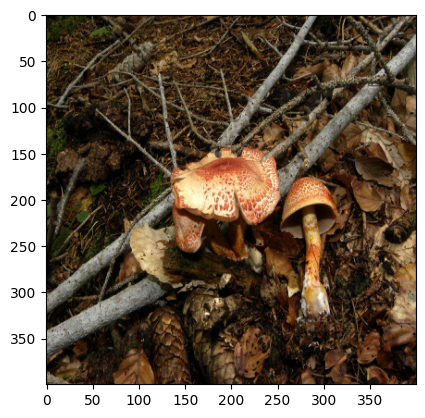

In [90]:
plt.imshow(X_[0]) , y_[0]

In [22]:
np.save("mushrooms",X_)

In [23]:
!ls

cloud_uploader.py  mushrooms  mushrooms.npy  test.ipynb


In [24]:
X_train = np.load("mushrooms.npy")

In [25]:
X_train.shape

(9, 400, 400, 3)

In [91]:
from sklearn.model_selection import train_test_split

## Waves

### Custom Model

In [6]:
#!pip install google-colab

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google.colab'

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("dark_background")

In [2]:
img = plt.imread("waves/Chaotic/HawaiBee__ocean__2022-11-24_18:06:49__1.png")
img.shape

(570, 1015, 4)

## We need to apply a series of transformations to this messy wave dataset

In [3]:
def crop_image(image):
    ## Your code
    return image   
    
def resize_image(image , image_width = 400 , image_height = 400):
    #feel free to modify interpolation
    return cv2.resize(image , (image_width , image_height) , interpolation = cv2.INTER_AREA)

def transform_channels(image):
    return cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

def make_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [4]:
resized_img = resize_image(img)
resized_img.shape

(400, 400, 4)

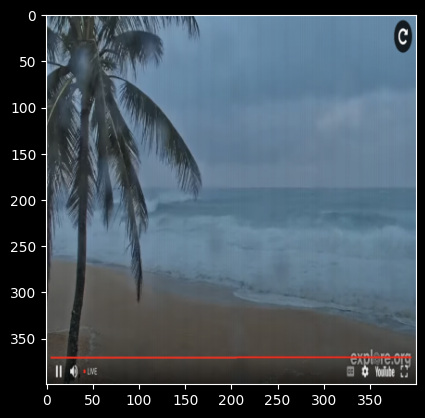

In [5]:
plt.imshow(resized_img , cmap = "gray")

In [6]:
resized_img.shape

(400, 400, 4)

In [7]:
transformed_img = transform_channels(resized_img)
transformed_img.shape

(400, 400, 3)

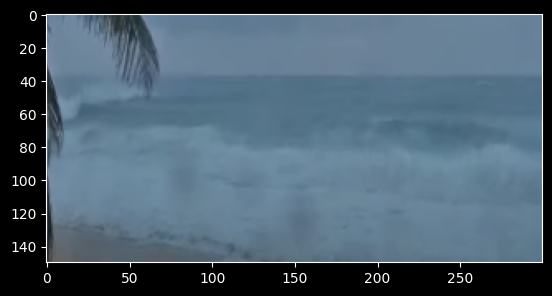

In [8]:
cropped_img = transformed_img[150:300,100:]
plt.imshow(cropped_img , cmap = "gray")

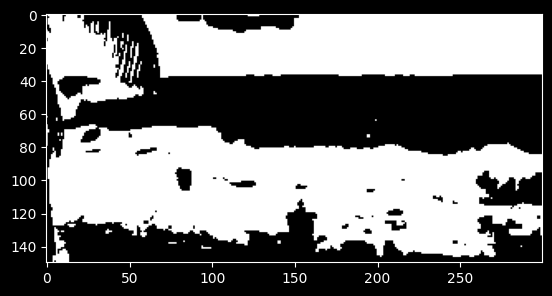

In [9]:
modified_img = (cropped_img[:,:,0] > 0.38).astype(np.uint8)
plt.imshow(modified_img , cmap = "gray")

In [10]:
### Thresholding on Blue Color
img_hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# lower mask (0-10)
lower_red = np.array([0,50,50])
upper_red = np.array([10,255,255])
mask0 = cv2.inRange(img_hsv, lower_red, upper_red)

# upper mask (170-180)
lower_red = np.array([170,50,50])
upper_red = np.array([180,255,255])
mask1 = cv2.inRange(img_hsv, lower_red, upper_red)

# join my masks
mask = mask0 + mask1

# set my output img to zero everywhere except my mask
output_img = img.copy()
output_img[np.where(mask==0)] = 0

# or your HSV image, which I *believe* is what you want
output_hsv = img_hsv.copy()
output_hsv[np.where(mask==0)] = 0

#### Use this site: https://htmlcolorcodes.com/ or pyautogui to detect color pixels

In [11]:
lower_blue = np.array([100, 100, 100])
upper_blue = np.array([255, 255, 255])
mask1 = cv2.inRange( (cropped_img*255).astype(np.int32), lower_blue, upper_blue)

In [12]:
output_img = cropped_img.copy()
output_img[np.where(mask1==0)] = 0

(-0.5, 299.5, 149.5, -0.5)

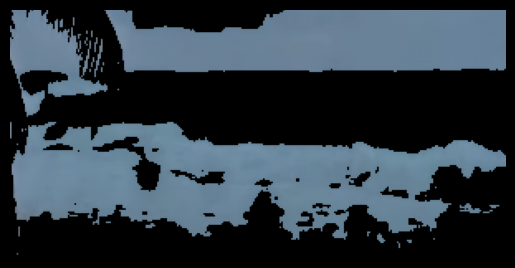

In [13]:
plt.imshow(output_img , cmap = "gray")
plt.axis("off")

In [14]:
def threshold_color(image):
    return image

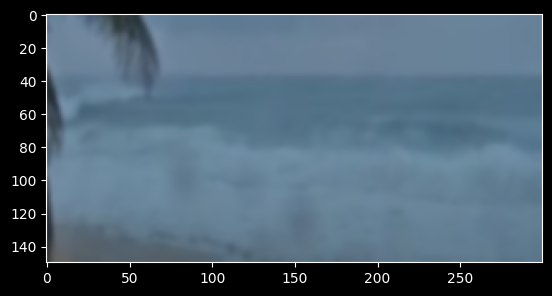

In [15]:
blurred = cv2.GaussianBlur(cropped_img, (7, 7), 0)
plt.imshow(blurred , cmap = "gray")

In [16]:
## u can also use masks
## masked = cv2.bitwise_and(image, image, mask=threshInv)

<a href="https://pyimagesearch.com/2021/04/28/opencv-thresholding-cv2-threshold/"> Thresholding </a>

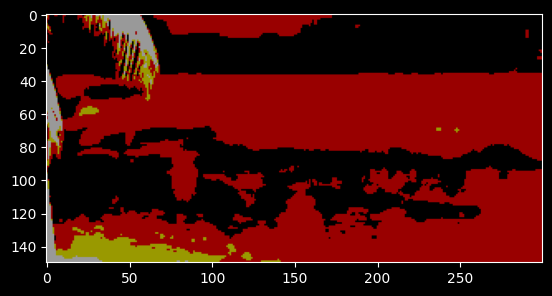

In [17]:
(T, thresh) = cv2.threshold(blurred, 0, 255,
                            cv2.THRESH_BINARY)  #cv2.THRESH_OTSU
(T, thresh) = cv2.threshold( cropped_img, 0.4, 0.6,
                            cv2.THRESH_BINARY_INV)  #cv2.THRESH_OTSU
plt.imshow(thresh , cmap = "gray")

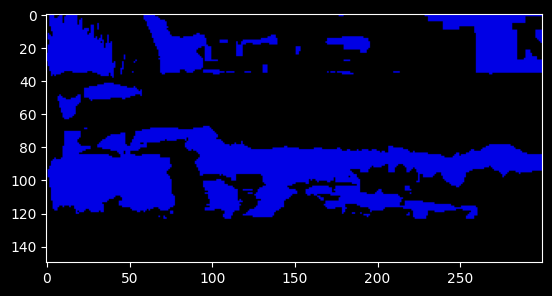

In [18]:
(T, thresh) = cv2.threshold(cropped_img, 0.6, 0.9, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap="gray")


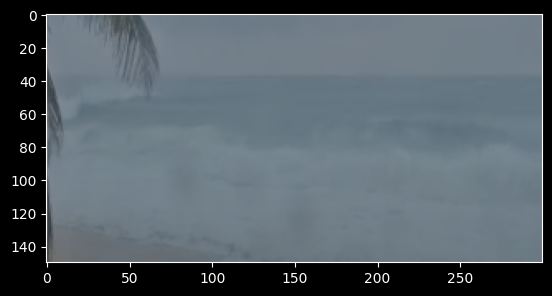

In [19]:
from skimage.exposure import adjust_gamma

modified = adjust_gamma(cropped_img , gamma = 0.5 , gain = 0.7)
plt.imshow(modified , cmap = "gray")

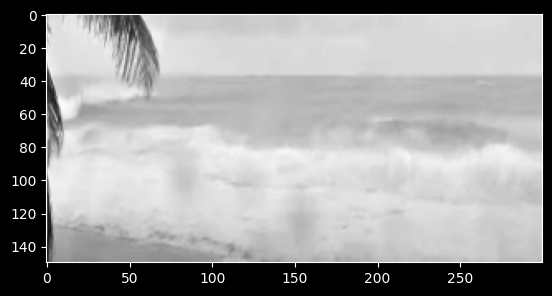

In [20]:
gray_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img,cmap="gray")

In [21]:
gray_img.shape

(150, 300)

In [22]:
gray_img = (gray_img*255).astype(np.uint8)

In [23]:
np.max(gray_img)

153

In [24]:
edges = cv2.Canny(gray_img, 0 , 20)

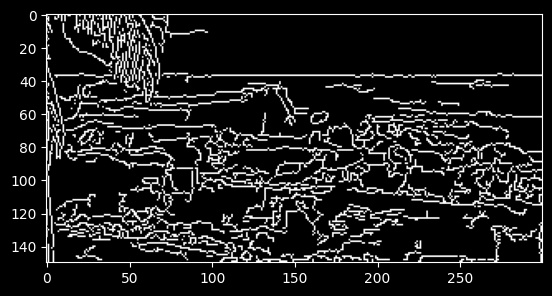

In [25]:
plt.imshow(edges , cmap = "gray")

### Pack all the transformations together

In [26]:
def preprocess_image(image):
    image = resize_image(image , image_width = 400 , image_height = 400)
    image = transform_channels(image)
    return image

### Create the preprocessed dataset (ideally you push it to google cloud storage)

In [36]:
## main Preprocessing Logic
## Can break.. need to break into chunks
import random
X = []
y = []
idx = 0

for root , dirs , files in os.walk("waves"):
    if dirs:
        parent = root
        folders = dirs
        print(folders)

    if files:
        print(f"Preprocessing folder {folders[idx]}...")
        for file in np.random.choice(np.array(files),10):
            try:
                original_image = plt.imread(os.path.join(parent , folders[idx], file))
                processed_image = preprocess_image(original_image)
                X.append(processed_image)
                y.append(idx)
            except Exception as e:
                print("Detected bad image!")
                continue
        idx += 1
X = np.array(X)
y = np.array(y)
X.shape , y.shape

['Good', 'Chaotic', 'Flat']
Preprocessing folder Good...
Detected bad image!
Preprocessing folder Chaotic...
Preprocessing folder Flat...


((29, 400, 400, 3), (29,))

In [53]:
def preprocess_chunk():
    pass

In [10]:
## main Preprocessing Logic
## Can break.. need to break into chunks
import random

X = []
y = []
idx = 0

def fetch_raw_images():
    idx = 0
    for root, dirs, files in os.walk("waves"):
        if dirs:
            parent = root
            folders = dirs
            print(folders)
        if files:
            print(f"Preprocessing folder {folders[idx]}...")
            for file in files:
                yield folders[idx] , file
            idx += 1

def preprocess_chunk(file):
    try:
        original_image = plt.imread(
            os.path.join(parent, folders[idx], file))
        processed_image = preprocess_image(original_image)
        X.append(processed_image)
        y.append(idx)
    except Exception as e:
        print("Detected bad image!")

X = np.array(X)
y = np.array(y)
X.shape, y.shape

((0,), (0,))

## Save preprocessed images

In [37]:
!mkdir preprocessed

In [41]:
np.save("preprocessed/images.npy",X)
np.save("preprocessed/label.npy" , y)

### Upload preprocessed images to cloud storage

In [3]:
import numpy as np

In [4]:
X = np.load("preprocessed/images.npy")
y = np.load("preprocessed/label.npy")
X.shape , y.shape

((29, 400, 400, 3), (29,))

## Basic CNN: Test

In [4]:
from keras import layers , models
from keras.optimizers import Adam

2022-11-29 03:01:49.684564: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
def initialize_model(X):
    
    model = models.Sequential()
    
    model.add(layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same', input_shape=X.shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Dropout(0.2))
  
    model.add(layers.Conv2D(64, (2, 2), activation = 'relu', padding = 'same'))
    model.add(layers.Dropout(0.3))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation = 'relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(3, activation = 'softmax'))
    
    return model

In [6]:
def compile_model(model  , learning_rate=1e-4):
    model.compile( loss = "categorical_crossentropy",
                            optimizer = Adam(learning_rate=learning_rate),
                            metrics = ["accuracy"])
    return model

In [7]:
print(X[0].shape)
model = initialize_model(X[0])
model = compile_model(model)

(400, 400, 3)


In [7]:
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping 

es = EarlyStopping(patience = 3 ,restore_best_weights=True)

2022-11-29 03:02:41.848090: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
np.unique(y , return_counts=True)

(array([0, 1, 2]), array([ 9, 10, 10]))

In [9]:
y_cat = to_categorical(y)
y_cat.shape

(29, 3)

In [6]:
X.shape

(29, 400, 400, 3)

In [11]:
model.fit(X , y_cat , epochs = 5 , batch_size = 256 , callbacks = [es])

Epoch 1/5


: 

: 